In [108]:
import optuna
import plotly
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_parallel_coordinate
# from optuna.visualization import plot_param_importances
# from optuna.visualization import plot_slice
print(plotly.__version__)  

5.18.0


In [109]:
# study_names = ["HC_full_default", "HC_full_eqaulize", "HC_full_descendants", "HC_full_reachable_leaf_nodes", "HC_full_CE"]
study_names = ["HC_BERT_max_evals10_eval_steps5"]
studies = []

for study_name in study_names:
    db_url = f"sqlite:///database/{study_name}.db"
    study = optuna.load_study(study_name=study_name, storage=db_url)
    studies.append(study)

/tmp/ipykernel_40865/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


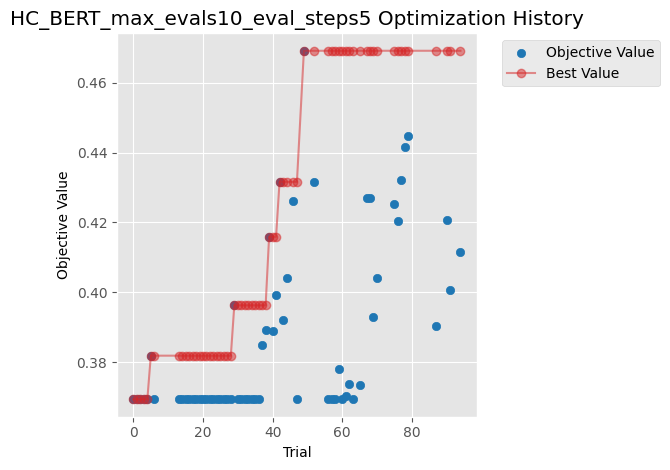

In [110]:
for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Optimization History")
    plt.show()

In [112]:
optuna.importance.get_param_importances(studies[0])

OrderedDict([('per_device_train_batch_size', 0.8195320628361792),
             ('loss_weight_method', 0.18005820068184852),
             ('weight_decay', 0.00040973648197234236)])

In [35]:
# dir(studies[0].trials[0])
studies[0].trials[0]._trial_id

1

In [113]:
data = []
for trial in studies[0].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        row["trial_id"] = trial._trial_id
        data.append(row)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data)

In [114]:
df.isna().sum()

learning_rate                  0
loss_weight_method             0
per_device_train_batch_size    0
weight_decay                   0
objective_value                0
trial_id                       0
dtype: int64

In [38]:
idx = df.index[df['per_device_train_batch_size'].isna()]
idx

Int64Index([495, 756], dtype='int64')

In [39]:
df.loc[idx]

,learning_rate,per_device_train_batch_size,weight_decay,objective_value,trial_id,loss_weight_method
495,0.000922,NaN,0.000004,0.394093,524,NaN
756,0.000060,NaN,0.000006,0.369427,797,NaN


In [41]:
df.loc[:10]

,learning_rate,per_device_train_batch_size,weight_decay,objective_value,trial_id,loss_weight_method
0,0.002445,5.0,0.000013,0.444468,1,NaN
1,0.000627,1.0,0.000976,0.369429,3,NaN
2,0.000090,12.0,0.000004,0.382426,4,NaN
3,0.009398,1.0,0.001813,0.408929,5,NaN
4,0.000013,10.0,0.000918,0.369427,6,NaN
5,0.000593,8.0,0.000032,0.413982,7,NaN
6,0.001649,1.0,0.002868,0.393803,8,NaN
7,0.000020,9.0,0.000035,0.369427,9,NaN
8,0.000204,9.0,0.000086,0.389952,10,NaN
9,0.003385,19.0,0.000009,0.478593,11,NaN


In [42]:
data = []
for trial in studies[1].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        row["trial_id"] = trial._trial_id
        data.append(row)

# Convert the data to a Pandas DataFrame
df2 = pd.DataFrame(data)
df2.isna().sum()

learning_rate                  1
per_device_train_batch_size    0
weight_decay                   0
objective_value                0
trial_id                       0
dtype: int64

In [46]:
idx = df2.index[df2['learning_rate'].isna()]
df2.loc[idx]

,learning_rate,per_device_train_batch_size,weight_decay,objective_value,trial_id
139,NaN,19,0.000054,0.474488,143


In [50]:
args = {"data_dir": 'dataset_'}

data_files = {
        'train': f"{args['data_dir']}/train_data.csv",
        'validation': f"{args['data_dir']}/val_data.csv",
        'test': f"{args['data_dir']}/test_data.csv"
    }

In [27]:
data = []
for trial in studies[2].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        data.append(row)

# Convert the data to a Pandas DataFrame
df3 = pd.DataFrame(data)
df3.isna().sum()

learning_rate                  0
per_device_train_batch_size    1
weight_decay                   0
objective_value                0
dtype: int64

In [28]:
data = []
for trial in studies[3].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        data.append(row)

# Convert the data to a Pandas DataFrame
df4 = pd.DataFrame(data)
df4.isna().sum()

learning_rate                    0
per_device_train_batch_size      0
weight_decay                     0
objective_value                  0
loss_weight_method             846
dtype: int64

/tmp/ipykernel_40865/3243345593.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


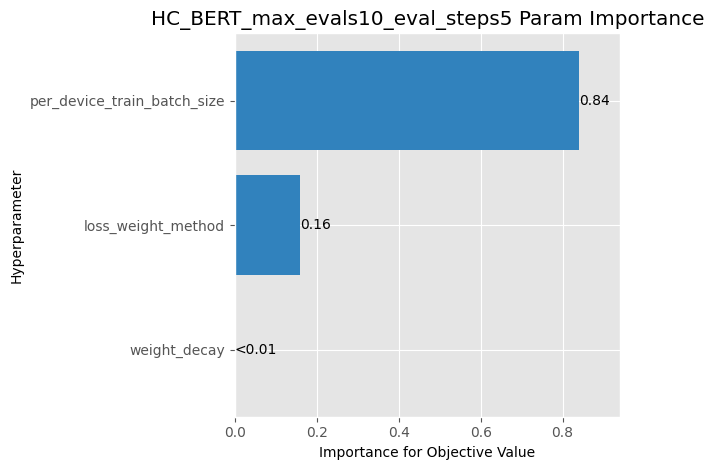

In [115]:
for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Param Importance")
    plt.show()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()

# sns.set_theme()
# sns.set_style("whitegrid")
# x = optuna.visualization.matplotlib.plot_param_importances(study_eqaulize)

# plt.tight_layout()
# plt.savefig('hpo_importance.png')
# plt.show()

/tmp/ipykernel_40865/308402206.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_40865/308402206.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


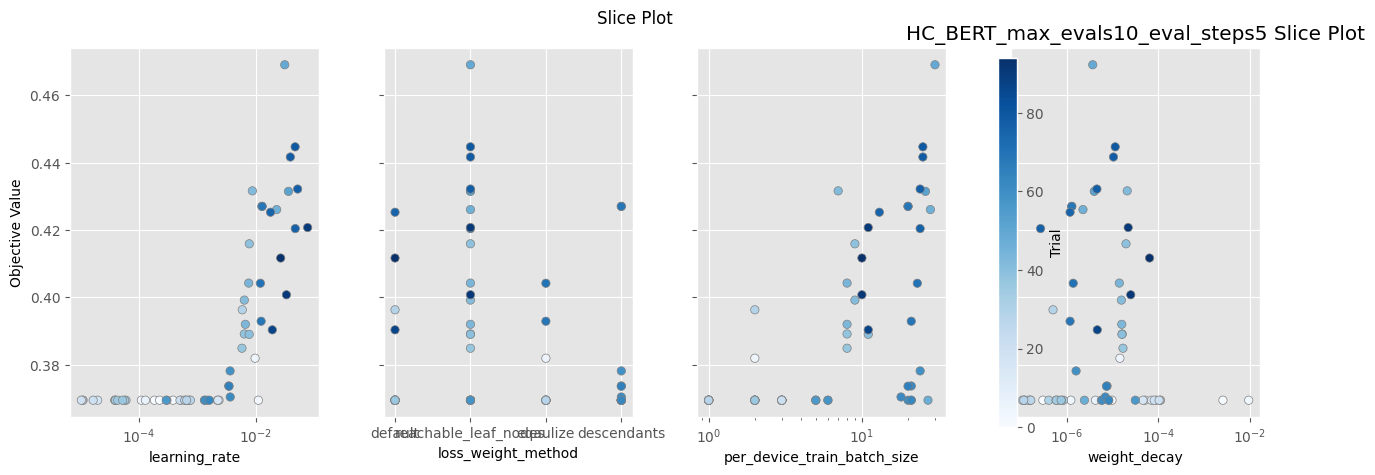

In [116]:
# Slice Plot

for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_slice(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Slice Plot")
    plt.show()

# optuna.visualization.matplotlib.plot_slice(study)
# plt.show()

In [117]:
n_best_trials = 3  # Number of best trials to show

# Get all the trials sorted by their completed values
all_trials = study.trials_dataframe()
sorted_trials = all_trials.sort_values("value", ascending=study.direction == "maximize")

# Print the best n trials
print(f"Top {n_best_trials} Trials:")
print(sorted_trials.head(n_best_trials))

Top 3 Trials:
    number     value             datetime_start          datetime_complete  \
49      49  0.469107 2023-10-31 22:18:09.509954 2023-10-31 22:45:26.586303   
79      79  0.444721 2023-10-31 23:39:52.197167 2023-11-01 00:06:30.584628   
78      78  0.441697 2023-10-31 23:32:16.637099 2023-10-31 23:59:14.676277   

                 duration  params_learning_rate params_loss_weight_method  \
49 0 days 00:27:17.076349              0.031348      reachable_leaf_nodes   
79 0 days 00:26:38.387461              0.047234      reachable_leaf_nodes   
78 0 days 00:26:58.039178              0.039112      reachable_leaf_nodes   

    params_per_device_train_batch_size  params_weight_decay  \
49                                  30             0.000004   
79                                  25             0.000011   
78                                  25             0.000011   

    system_attrs_completed_rung_0  system_attrs_completed_rung_1  \
49                       0.456247          

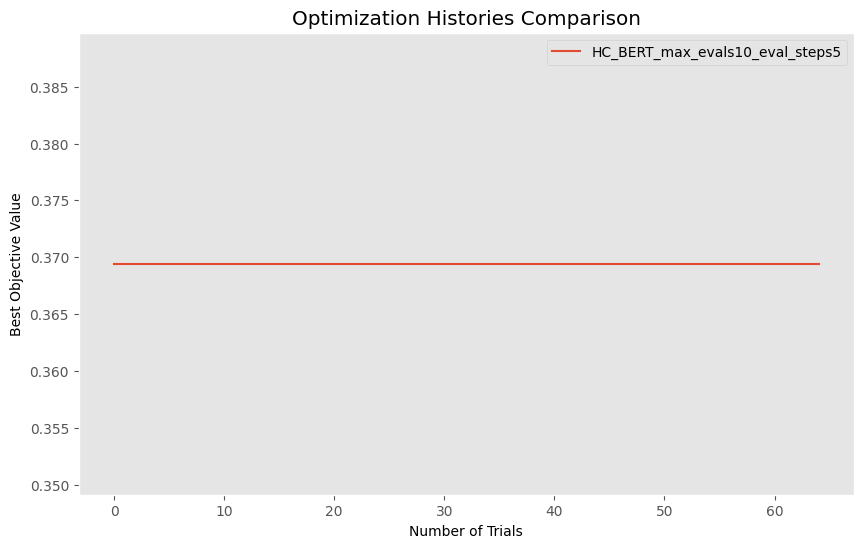

In [118]:
import matplotlib.pyplot as plt

def plot_optimization_histories(studies, study_names):
    plt.figure(figsize=(10, 6))

    for study, name in zip(studies, study_names):
        trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
        best_values = [float('inf')] * len(trials)
        for i, trial in enumerate(sorted(trials, key=lambda x: x.number)):
            if i > 0:
                best_values[i] = min(best_values[i - 1], trial.value)
            else:
                best_values[i] = trial.value
        
        plt.plot(best_values, label=name)

    plt.title("Optimization Histories Comparison")
    plt.xlabel("Number of Trials")
    plt.ylabel("Best Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_optimization_histories(studies, study_names)


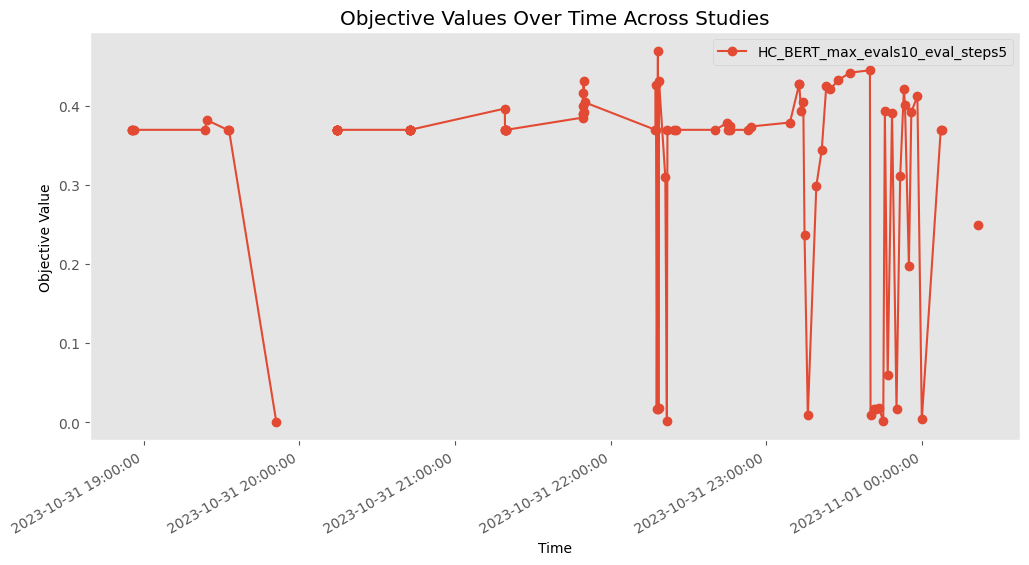

In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_values_over_time(studies, study_names):
    plt.figure(figsize=(12, 6))
    
    for study, name in zip(studies, study_names):
        trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
        trial_values = [trial.value for trial in study.trials]

        plt.plot(trial_timestamps, trial_values, marker='o', label=name)

    # Formatting the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.title("Objective Values Over Time Across Studies")
    plt.xlabel("Time")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_values_over_time(studies, study_names)
# don't smoothing

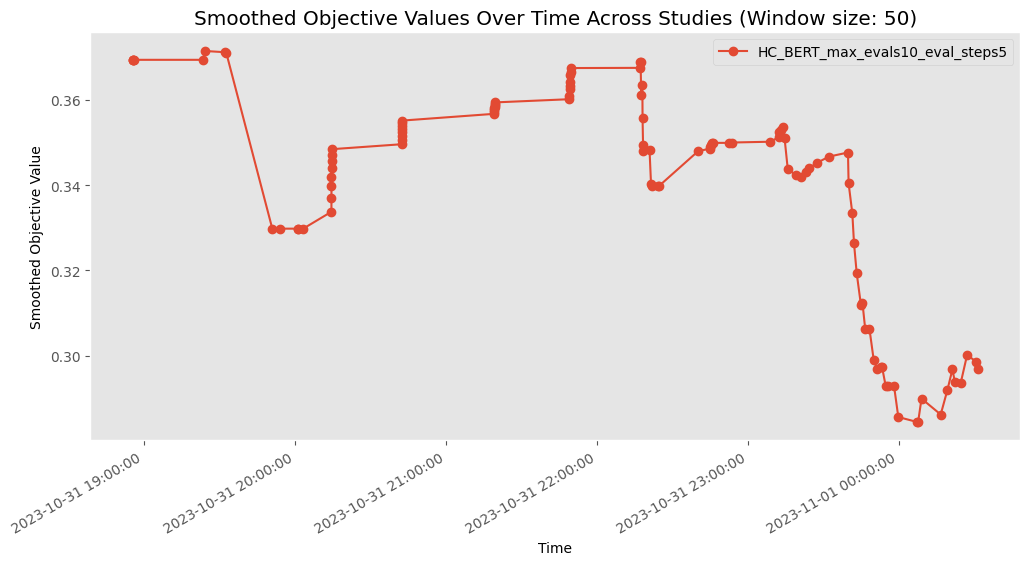

In [120]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

def smooth_values(values, window_size):
    """Apply a simple moving average smoothing."""
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

def plot_values_over_time_with_smoothing(studies, study_names, window_size=3):
    plt.figure(figsize=(12, 6))
    
    for study, name in zip(studies, study_names):
        trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
        trial_values = [trial.value for trial in study.trials]
        
        # Apply smoothing
        smoothed_values = smooth_values(trial_values, window_size)

        plt.plot(trial_timestamps, smoothed_values, marker='o', label=name)

    # Formatting the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.title(f"Smoothed Objective Values Over Time Across Studies (Window size: {window_size})")
    plt.xlabel("Time")
    plt.ylabel("Smoothed Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_values_over_time_with_smoothing(studies, study_names,window_size=50)


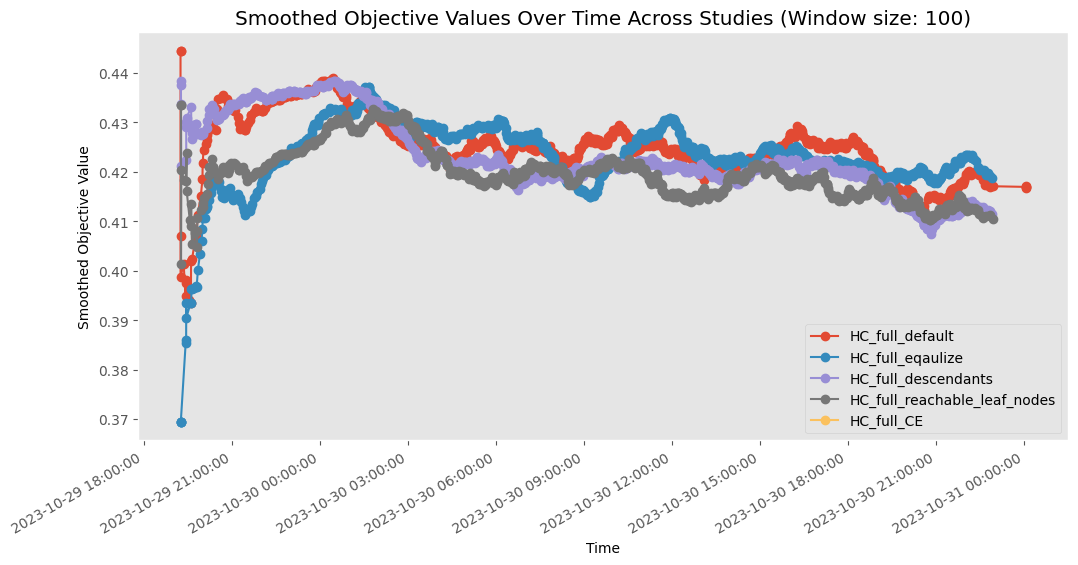

In [10]:
plot_values_over_time_with_smoothing(studies, study_names,window_size=100)

In [62]:
import pandas as pd

df = pd.read_csv('datasets_/MSR.csv')
df.head(10)

,Unnamed: 0,code,cwe_id,cve_id,vul
0,37,static PHP_FUNCTION(preg_match)\n{\n\tphp_do_p...,119,CVE-2015-8382,0
1,38,static PHP_FUNCTION(preg_match_all)\n{\n\tphp_...,119,CVE-2015-8382,0
2,39,static PHP_FUNCTION(preg_replace)\n{\n\tpreg_r...,119,CVE-2015-8382,0
3,40,static PHP_FUNCTION(preg_replace_callback)\n{\...,119,CVE-2015-8382,0
4,41,static PHP_FUNCTION(preg_filter)\n{\n\tpreg_re...,119,CVE-2015-8382,0
5,42,static PHP_FUNCTION(preg_split)\n{\n\tchar\t\t...,119,CVE-2015-8382,0
6,43,static PHP_FUNCTION(preg_quote)\n{\n\tint\t\t ...,119,CVE-2015-8382,0
7,44,static PHP_FUNCTION(preg_grep)\n{\n\tchar\t\t\...,119,CVE-2015-8382,0
8,45,static PHP_FUNCTION(preg_last_error)\n{\n\tif ...,119,CVE-2015-8382,0
9,46,static PHP_GINIT_FUNCTION(pcre) /* {{{ */\n{\n...,119,CVE-2015-8382,0


In [60]:
CVEfixes_df_chunk = pd.read_csv('datasets_/CVEfixes_new.csv', chunksize=1000)
print("CVEfixes_df_chunk is ready")

def read_csv_chunk(chunks):
    df_temp = []
    for chunk in chunks:
        df_temp.append(chunk)
    df = pd.concat(df_temp,ignore_index = True)
    return df

CVEfixes_df = read_csv_chunk(CVEfixes_df_chunk)

CVEfixes_df_chunk is ready


In [61]:
CVEfixes_df.head(10)

,code,cwe_id,cve_id,vul
0,"getlogin_r (name, name_len)\n char *name;\...",252.0,CVE-1999-0199,1.0
1,"getlogin_r (name, name_len)\n char *name;\...",252.0,CVE-1999-0199,1.0
2,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252.0,CVE-1999-0199,1.0
3,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252.0,CVE-1999-0199,1.0
4,main (void)\n{\n char *login;\n int errors =...,252.0,CVE-1999-0199,1.0
5,"_dl_dst_count (const char *name, int is_path)\...",252.0,CVE-1999-0199,1.0
6,"_dl_dst_count (const char *name, int is_path)\...",252.0,CVE-1999-0199,1.0
7,"_dl_dst_substitute (struct link_map *l, const ...",252.0,CVE-1999-0199,1.0
8,"_dl_dst_substitute (struct link_map *l, const ...",252.0,CVE-1999-0199,1.0
9,expand_dynamic_string_token (struct link_map *...,252.0,CVE-1999-0199,1.0


In [63]:
CVEfixes_df['cve_id'].value_counts()

CVE-2016-10096    14002
CVE-2022-0350      5522
CVE-2021-4103      4360
CVE-2022-1530      4166
CVE-2021-43515     3523
                  ...  
CVE-2021-37595        1
CVE-2017-7882         1
CVE-2019-19246        1
CVE-2021-37594        1
CVE-2022-21159        1
Name: cve_id, Length: 5297, dtype: int64

In [64]:
df['cve_id'].value_counts()

CVE-2016-5219     1520
CVE-2017-5120     1064
CVE-2012-5148     1053
CVE-2012-2875     1029
CVE-2018-13006     931
                  ... 
CVE-2017-17853       1
CVE-2016-3747        1
CVE-2017-16531       1
CVE-2010-1797        1
CVE-2017-13187       1
Name: cve_id, Length: 2858, dtype: int64

In [69]:
list1 = CVEfixes_df['cve_id'].value_counts().index.tolist()
list1

['CVE-2016-10096',
 'CVE-2022-0350',
 'CVE-2021-4103',
 'CVE-2022-1530',
 'CVE-2021-43515',
 'CVE-2022-1727',
 'CVE-2022-1730',
 'CVE-2022-2306',
 'CVE-2021-27340',
 'CVE-2021-27341',
 'CVE-2021-4097',
 'CVE-2021-41169',
 'CVE-2021-4123',
 'CVE-2014-1944',
 'CVE-2020-15211',
 'CVE-2022-2015',
 'CVE-2022-2014',
 'CVE-2020-21316',
 'CVE-2020-26301',
 'CVE-2021-3992',
 'CVE-2021-3983',
 'CVE-2018-11512',
 'CVE-2013-2025',
 'CVE-2021-3989',
 'CVE-2021-3121',
 'CVE-2022-0341',
 'CVE-2015-2972',
 'CVE-2015-4411',
 'CVE-2015-4410',
 'CVE-2020-5219',
 'CVE-2019-19274',
 'CVE-2019-19275',
 'CVE-2022-0401',
 'CVE-2016-8899',
 'CVE-2016-9020',
 'CVE-2016-7781',
 'CVE-2016-9087',
 'CVE-2016-8897',
 'CVE-2016-7788',
 'CVE-2016-8900',
 'CVE-2015-5074',
 'CVE-2015-5076',
 'CVE-2021-4000',
 'CVE-2016-6897',
 'CVE-2016-0721',
 'CVE-2020-15222',
 'CVE-2019-12548',
 'CVE-2021-41118',
 'CVE-2021-32470',
 'CVE-2015-2861',
 'CVE-2017-16806',
 'CVE-2018-17552',
 'CVE-2021-39177',
 'CVE-2021-25981',
 'CVE-202

In [68]:
list2 = df['cve_id'].value_counts().index.tolist()
list2

['CVE-2016-5219',
 'CVE-2017-5120',
 'CVE-2012-5148',
 'CVE-2012-2875',
 'CVE-2018-13006',
 'CVE-2017-9059',
 'CVE-2017-5019',
 'CVE-2016-3839',
 'CVE-2015-6763',
 'CVE-2013-0886',
 'CVE-2017-5112',
 'CVE-2017-6903',
 'CVE-2018-16427',
 'CVE-2018-6063',
 'CVE-2018-6096',
 'CVE-2013-0904',
 'CVE-2013-7271',
 'CVE-2011-4930',
 'CVE-2016-1621',
 'CVE-2015-1265',
 'CVE-2018-18352',
 'CVE-2012-2816',
 'CVE-2017-5009',
 'CVE-2016-10066',
 'CVE-2012-3552',
 'CVE-2012-2880',
 'CVE-2011-2350',
 'CVE-2017-5118',
 'CVE-2016-5170',
 'CVE-2012-2895',
 'CVE-2018-12714',
 'CVE-2011-4621',
 'CVE-2016-3751',
 'CVE-2016-1683',
 'CVE-2014-3173',
 'CVE-2017-5061',
 'CVE-2011-4324',
 'CVE-2018-6111',
 'CVE-2017-14604',
 'CVE-2016-2464',
 'CVE-2018-20784',
 'CVE-2017-5093',
 'CVE-2016-9557',
 'CVE-2011-3055',
 'CVE-2016-2476',
 'CVE-2011-2861',
 'CVE-2015-6773',
 'CVE-2011-2840',
 'CVE-2011-3896',
 'CVE-2012-5136',
 'CVE-2013-1929',
 'CVE-2018-17205',
 'CVE-2018-17206',
 'CVE-2015-6787',
 'CVE-2014-3645',
 

In [74]:
inter = set.intersection(set(list1), set(list2))
len(inter)

1391

In [75]:
inter

{'CVE-2016-4998',
 'CVE-2019-12818',
 'CVE-2016-5771',
 'CVE-2014-8176',
 'CVE-2016-6197',
 'CVE-2019-10639',
 'CVE-2016-6327',
 'CVE-2017-18241',
 'CVE-2015-4170',
 'CVE-2016-6561',
 'CVE-2010-1152',
 'CVE-2017-13040',
 'CVE-2015-6031',
 'CVE-2014-2673',
 'CVE-2018-8043',
 'CVE-2017-15385',
 'CVE-2012-6712',
 'CVE-2017-12858',
 'CVE-2016-10749',
 'CVE-2014-5353',
 'CVE-2017-12190',
 'CVE-2018-20182',
 'CVE-2017-9142',
 'CVE-2013-7024',
 'CVE-2019-11487',
 'CVE-2016-6130',
 'CVE-2018-20856',
 'CVE-2013-4129',
 'CVE-2018-10540',
 'CVE-2018-15120',
 'CVE-2014-9728',
 'CVE-2016-9794',
 'CVE-2016-7525',
 'CVE-2017-12427',
 'CVE-2016-7538',
 'CVE-2016-7526',
 'CVE-2013-2237',
 'CVE-2016-3841',
 'CVE-2016-4302',
 'CVE-2014-8323',
 'CVE-2019-9162',
 'CVE-2016-10172',
 'CVE-2017-13083',
 'CVE-2015-8897',
 'CVE-2019-12107',
 'CVE-2018-7998',
 'CVE-2018-1999015',
 'CVE-2017-7501',
 'CVE-2012-2669',
 'CVE-2018-5344',
 'CVE-2018-11379',
 'CVE-2015-2697',
 'CVE-2017-2584',
 'CVE-2014-8324',
 'CVE-2

In [82]:
code = df[df['cve_id']=='CVE-2017-12190'].tail(1)['code'].tolist()

In [84]:
print(code[0])

struct bio *bio_map_user_iov(struct request_queue *q,
			     const struct iov_iter *iter,
			     gfp_t gfp_mask)
{
	int j;
	int nr_pages = 0;
	struct page **pages;
	struct bio *bio;
	int cur_page = 0;
 	int ret, offset;
 	struct iov_iter i;
 	struct iovec iov;
 
 	iov_for_each(iov, i, *iter) {
 		unsigned long uaddr = (unsigned long) iov.iov_base;
		unsigned long len = iov.iov_len;
		unsigned long end = (uaddr + len + PAGE_SIZE - 1) >> PAGE_SHIFT;
		unsigned long start = uaddr >> PAGE_SHIFT;

		/*
		 * Overflow, abort
		 */
		if (end < start)
			return ERR_PTR(-EINVAL);

		nr_pages += end - start;
		/*
		 * buffer must be aligned to at least logical block size for now
		 */
		if (uaddr & queue_dma_alignment(q))
			return ERR_PTR(-EINVAL);
	}

	if (!nr_pages)
		return ERR_PTR(-EINVAL);

	bio = bio_kmalloc(gfp_mask, nr_pages);
	if (!bio)
		return ERR_PTR(-ENOMEM);

	ret = -ENOMEM;
	pages = kcalloc(nr_pages, sizeof(struct page *), gfp_mask);
	if (!pages)
		goto out;

	iov_for_each(iov, 

In [85]:
code2 = CVEfixes_df[CVEfixes_df['cve_id']=='CVE-2017-12190'].tail(1)['code'].tolist()
print(code2[0])

struct bio *bio_map_user_iov(struct request_queue *q,
			     const struct iov_iter *iter,
			     gfp_t gfp_mask)
{
	int j;
	int nr_pages = 0;
	struct page **pages;
	struct bio *bio;
	int cur_page = 0;
	int ret, offset;
	struct iov_iter i;
	struct iovec iov;

	iov_for_each(iov, i, *iter) {
		unsigned long uaddr = (unsigned long) iov.iov_base;
		unsigned long len = iov.iov_len;
		unsigned long end = (uaddr + len + PAGE_SIZE - 1) >> PAGE_SHIFT;
		unsigned long start = uaddr >> PAGE_SHIFT;

		/*
		 * Overflow, abort
		 */
		if (end < start)
			return ERR_PTR(-EINVAL);

		nr_pages += end - start;
		/*
		 * buffer must be aligned to at least logical block size for now
		 */
		if (uaddr & queue_dma_alignment(q))
			return ERR_PTR(-EINVAL);
	}

	if (!nr_pages)
		return ERR_PTR(-EINVAL);

	bio = bio_kmalloc(gfp_mask, nr_pages);
	if (!bio)
		return ERR_PTR(-ENOMEM);

	ret = -ENOMEM;
	pages = kcalloc(nr_pages, sizeof(struct page *), gfp_mask);
	if (!pages)
		goto out;

	iov_for_each(iov, i, *it

In [86]:
CVEfixes_df[CVEfixes_df['cve_id']=='CVE-2017-12190']

,code,cwe_id,cve_id,vul
30568,struct bio *bio_map_user_iov(struct request_qu...,772.0,CVE-2017-12190,1.0
30569,struct bio *bio_map_user_iov(struct request_qu...,772.0,CVE-2017-12190,1.0
30570,struct bio *bio_map_user_iov(struct request_qu...,772.0,CVE-2017-12190,1.0


In [95]:
CVEfixes_df[CVEfixes_df['cve_id']=='CVE-2017-12190'].duplicated(keep=False)

30568    False
30569     True
30570     True
dtype: bool

In [96]:
CVEfixes_df = CVEfixes_df.drop_duplicates()

In [97]:
CVEfixes_df

,code,cwe_id,cve_id,vul
0,"getlogin_r (name, name_len)\n char *name;\...",252.0,CVE-1999-0199,1.0
1,"getlogin_r (name, name_len)\n char *name;\...",252.0,CVE-1999-0199,1.0
2,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252.0,CVE-1999-0199,1.0
3,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252.0,CVE-1999-0199,1.0
4,main (void)\n{\n char *login;\n int errors =...,252.0,CVE-1999-0199,1.0
...,...,...,...,...
110901,"pam_converse (int num_msg, PAM_CONVERSE_ARG2_T...",763.0,CVE-2022-37451,1.0
110902,"host_name_lookup(void)\n{\nint old_pool, rc;\n...",787.0,CVE-2022-37452,1.0
110903,"host_name_lookup(void)\n{\nint old_pool, rc;\n...",787.0,CVE-2022-37452,1.0
110904,host_name_lookup_byaddr(void)\n{\nstruct hoste...,787.0,CVE-2022-37452,1.0


In [101]:
CVEfixes_df[CVEfixes_df['cve_id']=='CVE-2017-12190']

,code,cwe_id,cve_id,vul
30568,struct bio *bio_map_user_iov(struct request_qu...,772.0,CVE-2017-12190,1.0
30569,struct bio *bio_map_user_iov(struct request_qu...,772.0,CVE-2017-12190,1.0


In [105]:
cc = CVEfixes_df[CVEfixes_df['cve_id']=='CVE-2017-12190'].code.tolist()
len(set(cc))

2

In [106]:
print(cc[0])

struct bio *bio_map_user_iov(struct request_queue *q,
			     const struct iov_iter *iter,
			     gfp_t gfp_mask)
{
	int j;
	int nr_pages = 0;
	struct page **pages;
	struct bio *bio;
	int cur_page = 0;
	int ret, offset;
	struct iov_iter i;
	struct iovec iov;
	struct bio_vec *bvec;

	iov_for_each(iov, i, *iter) {
		unsigned long uaddr = (unsigned long) iov.iov_base;
		unsigned long len = iov.iov_len;
		unsigned long end = (uaddr + len + PAGE_SIZE - 1) >> PAGE_SHIFT;
		unsigned long start = uaddr >> PAGE_SHIFT;

		/*
		 * Overflow, abort
		 */
		if (end < start)
			return ERR_PTR(-EINVAL);

		nr_pages += end - start;
		/*
		 * buffer must be aligned to at least logical block size for now
		 */
		if (uaddr & queue_dma_alignment(q))
			return ERR_PTR(-EINVAL);
	}

	if (!nr_pages)
		return ERR_PTR(-EINVAL);

	bio = bio_kmalloc(gfp_mask, nr_pages);
	if (!bio)
		return ERR_PTR(-ENOMEM);

	ret = -ENOMEM;
	pages = kcalloc(nr_pages, sizeof(struct page *), gfp_mask);
	if (!pages)
		goto out;

	i

In [107]:
print(cc[1])

struct bio *bio_map_user_iov(struct request_queue *q,
			     const struct iov_iter *iter,
			     gfp_t gfp_mask)
{
	int j;
	int nr_pages = 0;
	struct page **pages;
	struct bio *bio;
	int cur_page = 0;
	int ret, offset;
	struct iov_iter i;
	struct iovec iov;

	iov_for_each(iov, i, *iter) {
		unsigned long uaddr = (unsigned long) iov.iov_base;
		unsigned long len = iov.iov_len;
		unsigned long end = (uaddr + len + PAGE_SIZE - 1) >> PAGE_SHIFT;
		unsigned long start = uaddr >> PAGE_SHIFT;

		/*
		 * Overflow, abort
		 */
		if (end < start)
			return ERR_PTR(-EINVAL);

		nr_pages += end - start;
		/*
		 * buffer must be aligned to at least logical block size for now
		 */
		if (uaddr & queue_dma_alignment(q))
			return ERR_PTR(-EINVAL);
	}

	if (!nr_pages)
		return ERR_PTR(-EINVAL);

	bio = bio_kmalloc(gfp_mask, nr_pages);
	if (!bio)
		return ERR_PTR(-ENOMEM);

	ret = -ENOMEM;
	pages = kcalloc(nr_pages, sizeof(struct page *), gfp_mask);
	if (!pages)
		goto out;

	iov_for_each(iov, i, *it

In [98]:
df.shape

(145743, 5)

In [99]:
df = df.drop_duplicates()

In [100]:
df

,Unnamed: 0,code,cwe_id,cve_id,vul
0,37,static PHP_FUNCTION(preg_match)\n{\n\tphp_do_p...,119,CVE-2015-8382,0
1,38,static PHP_FUNCTION(preg_match_all)\n{\n\tphp_...,119,CVE-2015-8382,0
2,39,static PHP_FUNCTION(preg_replace)\n{\n\tpreg_r...,119,CVE-2015-8382,0
3,40,static PHP_FUNCTION(preg_replace_callback)\n{\...,119,CVE-2015-8382,0
4,41,static PHP_FUNCTION(preg_filter)\n{\n\tpreg_re...,119,CVE-2015-8382,0
...,...,...,...,...,...
145738,188631,void impeg2d_dec_p_mb_params(dec_state_t *ps_d...,119,CVE-2016-0835,1
145739,188632,void impeg2d_dec_pnb_mb_params(dec_state_t *ps...,119,CVE-2016-0835,1
145740,188633,int equalizer_get_parameter(effect_context_t *...,200,CVE-2017-0402,1
145741,188634,"uint8_t rfc_parse_data(tRFC_MCB* p_mcb, MX_FRA...",125,CVE-2018-9503,1
